In [ ]:
#Resources
#http://patrickgray.me/open-geo-tutorial/chapter_3_visualization.html
#https://geohackweek.github.io/raster/04-workingwithrasters/
#https://datacarpentry.org/r-raster-vector-geospatial/
#https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python/

# Bilberries in Southern Finland

**Objective:** to identify potentially suitable sites for harvesting bilberries in southern Finland
    
In this project, I rely on open data from Luke - the Natural Resources Institute of Finland - and the Finnish Meteorological Institute to identify and rank sites for harvesting wild bilberries.

According to research from Ihalainen, et al. (2005), high bilberry yields are mostly found in mature forest stands of medium fertility and dominated by spruce. According to a study by Tahvanainen et al. (2019), climatic factors like precipation affect berry yields in different ways during different stages of berry development.

I downloaded data on soil fertility, stand diameter, spruce volume from Luke and precipitation data from the Finnish Meteorological Institute and reclassified the raster data to assess likelihood of high, medium, or low wild berry yields. I focused on southern Finland and two local areas within the Uusimaa region.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterio.merge import merge
from shapely.geometry import box
from fiona.crs import from_epsg

In C:\Users\rache\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\rache\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\rache\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\rache\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\rache\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

## PREPARING FILES

### SITE FERTILITY

Luke has soil fertility data from 2017 available in its open data file service (http://kartta.luke.fi/index-en.html)

In [2]:
#site fertility
fert_l3 = 'C:/Users/rache/Downloads/data_science/berries/kasvupaikka_vmi1x_1317_L3.tif'
fert_l4 = 'C:/Users/rache/Downloads/data_science/berries/kasvupaikka_vmi1x_1317_L4.tif'
fert_l5 = 'C:/Users/rache/Downloads/data_science/berries/kasvupaikka_vmi1x_1317_L5.tif'
fert_raster_l3 = rasterio.open(fert_l3)
image = fert_raster_l3.read()

type(fert_raster_l3)

rasterio.io.DatasetReader

In [20]:
fert_raster_l3.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': 32767.0,
 'width': 12000,
 'height': 6000,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:3067'),
 'transform': Affine(16.0, 0.0, 116000.0,
        0.0, -16.0, 6762000.0)}

In [21]:
band = fert_raster_l3.read(1)

In [22]:
minimum = band.min()
avg = band.mean()
med = np.median(band)
maximum = band.max()

print('Soil Fertility L3')
print('Min: ', minimum)
print('Mean: ', avg)
print('Median: ', med)
print('Max: ', maximum)

Soil Fertility L3
Min:  1
Mean:  21333.661549069446
Median:  32767.0
Max:  32767


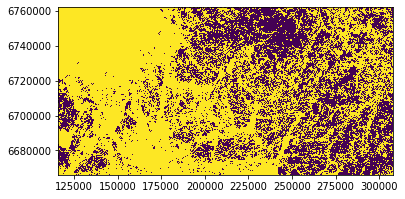

In [39]:
show((fert_raster_l3, 1))

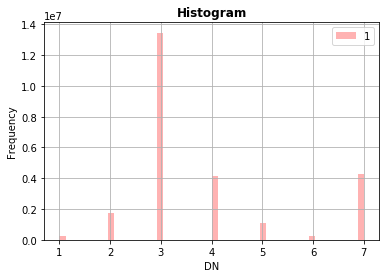

In [40]:
show_hist(fert_raster_l3, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title="Histogram - Site Fertility L3")

In [20]:
#gets the first band
first_band = image[0, :, :]

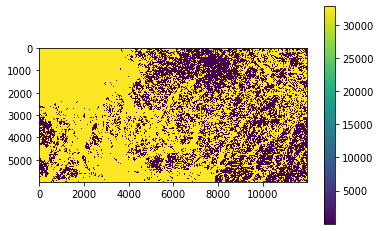

In [21]:
#plotting with color band
fig, ax = plt.subplots()
img = ax.imshow(first_band) 
fig.colorbar(img, ax=ax)

In [3]:
#import other site fertility files
fp_l4 = 'C:/Users/rache/Downloads/data_science/berries/kasvupaikka_vmi1x_1317_L4.tif'
fp_l5 = 'C:/Users/rache/Downloads/data_science/berries/kasvupaikka_vmi1x_1317_L5.tif'

fert_raster_l4 = rasterio.open(fp_l4)
fert_raster_l5 = rasterio.open(fp_l5)

#### Merging Raster Files

<AxesSubplot:>

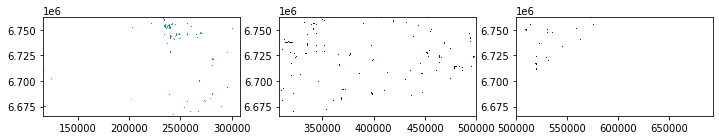

In [24]:
#plotting side-by-side
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 3))

# Plot first four files
show(fert_raster_l3, ax=ax1)
show(fert_raster_l4, ax=ax2)
show(fert_raster_l5, ax=ax3)

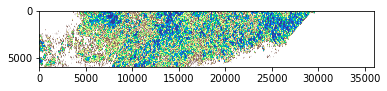

<AxesSubplot:>

In [5]:
#merging raster files
src_files_to_merge = [fert_raster_l3, fert_raster_l4, fert_raster_l5]

# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = rasterio.merge.merge(src_files_to_merge)

# Plot the result
show(mosaic, cmap='terrain')

In [6]:
# Copy the metadata
out_meta = fert_raster_l3.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": fert_raster_l3.crs.data
                 }
                )

In [7]:
out_fp = 'C:/Users/rache/Downloads/data_science/berries/site_fert_mosaic.tif'
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

### STAND DIAMETER

In [ ]:
Average diameter of trees (cm)

In [8]:
#stand diameter
stand_l3 = 'C:/Users/rache/Downloads/data_science/berries/keskilapimitta_vmi1x_1317_L3.tif'
stand_l4 = 'C:/Users/rache/Downloads/data_science/berries/keskilapimitta_vmi1x_1317_L4.tif'
stand_l5 = 'C:/Users/rache/Downloads/data_science/berries/keskilapimitta_vmi1x_1317_L5.tif'
stand_raster_l3 = rasterio.open(stand_l3)
stand_raster_l4 = rasterio.open(stand_l4)
stand_raster_l5 = rasterio.open(stand_l5)
image = stand_raster_l3.read()

type(stand_raster_l3)

rasterio.io.DatasetReader

In [51]:
stand_raster_l3.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': 32767.0,
 'width': 12000,
 'height': 6000,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:3067'),
 'transform': Affine(16.0, 0.0, 116000.0,
        0.0, -16.0, 6762000.0)}

In [23]:
band = stand_raster_l3.read(1)
minimum = band.min()
avg = band.mean()
med = np.median(band)
maximum = band.max()

print('Stand Diameter L3')
print('Min: ', minimum)
print('Mean: ', avg)
print('Median: ', med)
print('Max: ', maximum)

Stand Diameter
Min:  0
Mean:  21338.200616277776
Median:  32767.0
Max:  32767


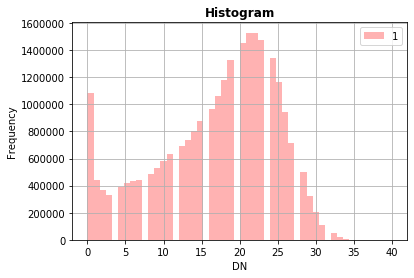

In [24]:
show_hist(stand_raster_l3, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title="Histogram - Stand Diameter L3")

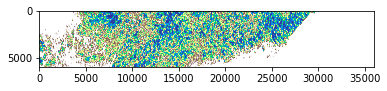

In [9]:
#merging raster files
src_files_to_merge = [stand_raster_l3, stand_raster_l4, stand_raster_l5]

# Merge function returns a single mosaic array and the transformation info
stand_mosaic, out_trans = rasterio.merge.merge(src_files_to_merge)

# Plot the result
show(stand_mosaic, cmap='terrain')

out_meta = stand_raster_l3.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": stand_mosaic.shape[1],
                 "width": stand_mosaic.shape[2],
                 "transform": out_trans,
                 "crs": stand_raster_l3.crs.data
                 }
                )
#"crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "

#outputting merged file
out_fp = 'C:/Users/rache/Downloads/data_science/berries/stand_diameter_mosaic.tif'
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(stand_mosaic)

### SPRUCE VOLUME

Spruce, body volume (m3 / ha)


In [10]:
#spruce volume
spruce_l3 = 'C:/Users/rache/Downloads/data_science/berries/manty_vmi1x_1317_L3.tif'
spruce_l4 = 'C:/Users/rache/Downloads/data_science/berries/manty_vmi1x_1317_L4.tif'
spruce_l5 = 'C:/Users/rache/Downloads/data_science/berries/manty_vmi1x_1317_L5.tif'
spruce_raster_l3 = rasterio.open(spruce_l3)
spruce_raster_l4 = rasterio.open(spruce_l4)
spruce_raster_l5 = rasterio.open(spruce_l5)
image = spruce_raster_l3.read()

type(spruce_raster_l3)

rasterio.io.DatasetReader

In [55]:
spruce_raster_l3.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': 32767.0,
 'width': 12000,
 'height': 6000,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:3067'),
 'transform': Affine(16.0, 0.0, 116000.0,
        0.0, -16.0, 6762000.0)}

In [26]:
band = spruce_raster_l3.read(1)
minimum = band.min()
avg = band.mean()
med = np.median(band)
maximum = band.max()

print('Spruce Volume L3')
print('Min: ', minimum)
print('Mean: ', avg)
print('Median: ', med)
print('Max: ', maximum)

Spruce Volume L3
Min:  0
Mean:  21354.441144166667
Median:  32767.0
Max:  32767


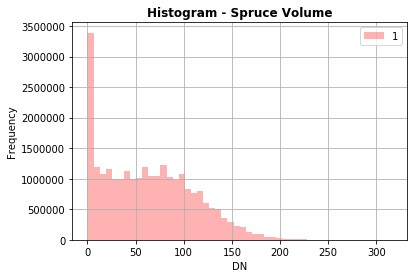

In [27]:
show_hist(spruce_raster_l3, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title="Histogram - Spruce Volume L3")

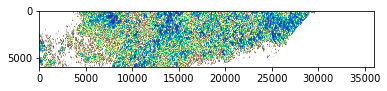

In [11]:
#merging raster files
src_files_to_merge = [spruce_raster_l3, spruce_raster_l4, spruce_raster_l5]

# Merge function returns a single mosaic array and the transformation info
spruce_mosaic, out_trans = rasterio.merge.merge(src_files_to_merge)

# Plot the result
show(spruce_mosaic, cmap='terrain')

out_meta = spruce_raster_l3.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": spruce_mosaic.shape[1],
                 "width": spruce_mosaic.shape[2],
                 "transform": out_trans,
                 "crs": spruce_raster_l3.crs.data
                 }
                )

#outputting merged file
out_fp = 'C:/Users/rache/Downloads/data_science/berries/spruce_volume_mosaic.tif'
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(spruce_mosaic)

### PRECIPITATION

# RASTER ALGEBRA

### Reclassifying rasters

In [12]:
#read in merged files
fert_path = 'C:/Users/rache/Downloads/data_science/berries/site_fert_mosaic.tif'
stand_path = 'C:/Users/rache/Downloads/data_science/berries/stand_diameter_mosaic.tif'
spruce_path = 'C:/Users/rache/Downloads/data_science/berries/spruce_volume_mosaic.tif'
site_fert_raster = rasterio.open(fert_path)
stand_diam_raster = rasterio.open(stand_path)
spruce_vol_raster = rasterio.open(spruce_path)

In [ ]:
#convert to np array
site_fert_array = site_fert_raster.read(1)
stand_diam_array = stand_diam_raster.read(1)
spruce_vol_array = spruce_vol_raster.read(1)

In [4]:
#convert to floats
site_fert = site_fert_array.astype('f4')
stand_diam = stand_diam_array.astype('f4')
spruce_vol = spruce_vol_array.astype('f4')

- class 1 is herb rich sites
- class 2 is herb rich heath forests
- class 3 is mesic forests
- class 4 is sub-xeric forests
- class 5 is xeric forests
- class 6 is barren forests 
- class 7 (rocky and sandy soils and alluvial lands) can be forest land, poorly productive forest land, or unproductive land
- class 8 (summit and fjeld land with single coniferous trees) is either poorly productive forest land or unproductive land
- class 9 (mountain birch dominated fjelds) is poorly productive forest land or unproductive land
- class 10 (Open fjelds) is poorly productive forest land or unproductive land


- 32766  pixel where result should have been computed but it was not possible because of, e.g., clouds
- 32767  pixel that is outside forest land, poorly productive land, or unproductive land, or is not in Finland

In [4]:
print('Soil Fertility')
print('Min: ', site_fert.min())
print('Max: ', site_fert.max())
print('Mean: ', site_fert.mean())

Soil Fertility
Min:  1.0
Max:  32767.0
Mean:  21633.15


In [5]:
#view categories
uniq_vals = np.unique(site_fert)
print(sorted(uniq_vals))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 32766.0, 32767.0]


Reclass site fertility:
- classes 1-4: good
- classed 5-10: bad

In [5]:
#reclassifying
site_fert[site_fert <= 4] = 2
site_fert[(5 <= site_fert) & (site_fert <= 11)] = 1
site_fert[site_fert >= 30000] = -1

In [44]:
uniq_vals = np.unique(site_fert)
print(sorted(uniq_vals))

[-1.0, 1.0, 2.0]


In [45]:
# counting new categories
print("Good: ", np.sum(site_fert == 2))
print("Poor: ", np.sum(site_fert == 1))
#print(np.sum(site_fert == 32766.0))
#print(np.sum(site_fert == 32767.0))

Good:  65029479
Poor:  8373409


In [ ]:
show_hist(temp, bins=20, lw=0.0, stacked=False, alpha=0.3, 
          histtype='stepfilled', title="Histogram - Soil Fertility")

In [16]:
print('Stand Diameter')
print('Min: ', stand_diam.min())
print('Max: ',stand_diam.max())
print('Mean: ',stand_diam.mean())

Stand Diameter
Min:  0.0
Max:  32767.0
Mean:  21637.613


Reclass stand diameter:
- 0-9: low
- 10-23: medium
- 24+: high

In [6]:
#reclassifying
stand_diam[(0 <= stand_diam) & (stand_diam <= 9)] = 1
stand_diam[(10 <= stand_diam) & (stand_diam <= 23)] = 2
stand_diam[(24 <= stand_diam) & (stand_diam <= 30000)] = 3
stand_diam[stand_diam >= 31000] = -1

In [47]:
uniq_vals = np.unique(stand_diam)
print(sorted(uniq_vals))

[-1.0, 1.0, 2.0, 3.0]


In [24]:
# counting new categories
print("Low: ", np.sum(stand_diam == 1))
print("Medium: ", np.sum(stand_diam == 2))
print("High: ", np.sum(stand_diam == 3))

Low:  14764535
Medium:  44209957
High:  14428396
917
142596195


In [15]:
print("Spruce Volume")
print('Min: ', spruce_vol.min())
print('Max: ', spruce_vol.max())
print('Mean: ', spruce_vol.mean())

Spruce Volume
Min:  0.0
Max:  32767.0
Mean:  21650.512


Reclass spruce volume:
- 0-3 m3/ha: low
- 4-95 m3/ha: medium
- 96+: high

In [7]:
#reclassifying
spruce_vol[(0 <= spruce_vol) & (spruce_vol <= 3)] = 1
spruce_vol[(4 <= spruce_vol) & (spruce_vol <= 95)] = 2
spruce_vol[(96 <= spruce_vol) & (spruce_vol <= 30000)] = 3
spruce_vol[spruce_vol >= 31000] = -1

In [49]:
uniq_vals = np.unique(spruce_vol)
print(sorted(uniq_vals))

[-1.0, 1.0, 2.0, 3.0]


In [28]:
print("Low: ", np.sum(spruce_vol == 1))
print("Medium: ", np.sum(spruce_vol == 2))
print("High: ", np.sum(spruce_vol == 3))

Low:  11197106
Medium:  46618715
High:  15587067


### Weighted Overlay

In [8]:
#example calculation
wt_avg = site_fert*.5 + stand_diam *.3 + spruce_vol *.2

In [19]:
wt_avg[0]

array([32767.002, 32767.002, 32767.002, ..., 32767.002, 32767.002,
       32767.002], dtype=float32)

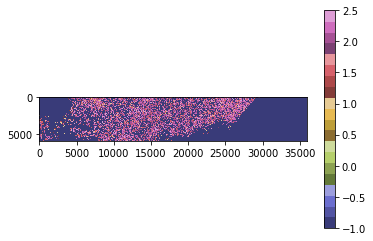

In [55]:
#plotting calculation
plt.imshow(wt_avg, cmap = 'tab20b')
# Add colorbar to show the index
plt.colorbar()

### Overlay Polygon

In [13]:
# bounding box for summer cottage
# WGS84 coordinates
#mokki coordinates: 60.2333, 23.3222

# LARGER AREA
minx, miny = 23.31, 60.23
maxx, maxy = 23.34, 60.24
bbox = box(minx, miny, maxx, maxy)

In [14]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
print(geo)

                                            geometry
0  POLYGON ((23.34000 60.23000, 23.34000 60.24000...


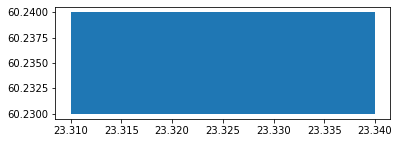

In [15]:
import descartes

geo.plot()
plt.show()

In [18]:
#confirm that merged rasters have same crs
print(site_fert_raster.crs == stand_diam_raster.crs)
print(spruce_vol_raster.crs == site_fert_raster.crs)

True
True


In [19]:
# Project the Polygon into same CRS as the grid
geo = geo.to_crs(crs=site_fert_raster.crs.data)

# Print crs
geo.crs

{'init': 'epsg:3067'}

In [20]:
#Reformat the coordinates of the geometry so that rasterio can read them
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[297342.27577274165, 6682647.622772045], [297404.05316565733, 6683760.18659111], [295744.59229909396, 6683852.714865289], [295682.3081997322, 6682740.1700613545], [297342.27577274165, 6682647.622772045]]]}]


In [23]:
# Clip the three rasters with Polygon
#out_img, out_transform = mask(dataset=site_fert_raster, shapes=coords, crop=True)
out_img_f, out_transform_f = mask(dataset=site_fert_raster, shapes=coords, crop=True)
out_img_st, out_transform_st = mask(dataset=stand_diam_raster, shapes=coords, crop=True)
out_img_sp, out_transform_sp = mask(dataset=spruce_vol_raster, shapes=coords, crop=True)

In [25]:
# Copy the metadata from each raster
#out_meta = site_fert_raster.meta.copy()
#print(out_meta)

out_meta_f = site_fert_raster.meta.copy()
print(out_meta_f)

out_meta_st = stand_diam_raster.meta.copy()
print(out_meta_st)

out_meta_sp = spruce_vol_raster.meta.copy()
print(out_meta_sp)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 32767.0, 'width': 36000, 'height': 6000, 'count': 1, 'crs': CRS.from_dict(init='epsg:3067'), 'transform': Affine(16.0, 0.0, 116000.0,
       0.0, -16.0, 6762000.0)}
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 32767.0, 'width': 36000, 'height': 6000, 'count': 1, 'crs': CRS.from_dict(init='epsg:3067'), 'transform': Affine(16.0, 0.0, 116000.0,
       0.0, -16.0, 6762000.0)}
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 32767.0, 'width': 36000, 'height': 6000, 'count': 1, 'crs': CRS.from_dict(init='epsg:3067'), 'transform': Affine(16.0, 0.0, 116000.0,
       0.0, -16.0, 6762000.0)}


In [26]:
#update the metadata with new dimensions, transform (affine) and CRS
import pycrs
# "crs": pycrs.parser.from_epsg_code(epsg_code).to_proj4()}

#out_meta.update({"driver": "GTiff",
#                 "height": out_img.shape[1],
#                 "width": out_img.shape[2],
#                 "transform": out_transform,
#                 "crs": raster.crs.data}
#                         )

#update the metadata with new dimensions, transform (affine) and CRS
#import pycrs
# "crs": pycrs.parser.from_epsg_code(epsg_code).to_proj4()}

out_meta_f.update({"driver": "GTiff",
                 "height": out_img_f.shape[1],
                 "width": out_img_f.shape[2],
                 "transform": out_transform_f,
                 "crs": site_fert_raster.crs.data}
                         )

out_meta_st.update({"driver": "GTiff",
                 "height": out_img_st.shape[1],
                 "width": out_img_st.shape[2],
                 "transform": out_transform_st,
                 "crs": stand_diam_raster.crs.data}
                         )

out_meta_sp.update({"driver": "GTiff",
                 "height": out_img_sp.shape[1],
                 "width": out_img_sp.shape[2],
                 "transform": out_transform_sp,
                 "crs": spruce_vol_raster.crs.data}
                         )

In [27]:
#save the clipped rasters
fert_tif = 'C:/Users/rache/Downloads/data_science/berries/Mokki_fert_clipped.tif'
stand_tif ='C:/Users/rache/Downloads/data_science/berries/Mokki_stand_clipped.tif'
spruce_tif = 'C:/Users/rache/Downloads/data_science/berries/Mokki_spruce_clipped.tif'

with rasterio.open(fert_tif, "w", **out_meta_f) as dest:
        dest.write(out_img_f)

with rasterio.open(stand_tif, "w", **out_meta_st) as dest:
        dest.write(out_img_st)
        
with rasterio.open(spruce_tif, "w", **out_meta_sp) as dest:
        dest.write(out_img_sp)

<AxesSubplot:>

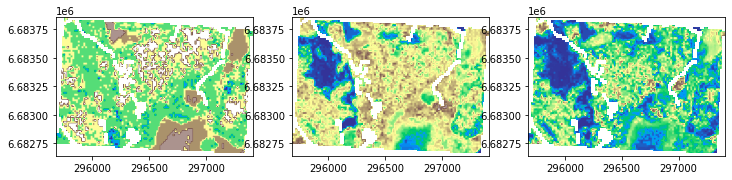

In [30]:
# Open the clipped raster file
site_fert = rasterio.open(fert_tif)
stand_diam = rasterio.open(stand_tif)
spruce_vol =rasterio.open(spruce_tif)

# Visualize
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 3))

show((site_fert), ax=ax1, cmap='terrain')
show((stand_diam), ax=ax2, cmap='terrain')
show((spruce_vol), ax=ax3, cmap='terrain')

#### Weighted Overlay - Summer Cottage (Mökki)

In [31]:
mokki_fert = rasterio.open(fert_tif)
mokki_fert = mokki_fert.read(1)

#convert to floats
mokki_fert = mokki_fert.astype('f4')

In [32]:
#reclassifying
#classes 1-4: good
#classed 5-10: bad
    
mokki_fert[mokki_fert <= 4] = 2
mokki_fert[(5 <= mokki_fert) & (mokki_fert <= 11)] = 1
mokki_fert[mokki_fert >= 30000] = -1

In [33]:
mokki_stand = rasterio.open(stand_tif)
mokki_stand = mokki_stand.read(1)

#convert to float
mokki_stand = mokki_stand.astype('f4')

In [34]:
#reclassifying
#0-9: low
#10-23: medium
#24+: high

mokki_stand[(0 <= mokki_stand) & (mokki_stand <= 9)] = 1
mokki_stand[(10 <= mokki_stand) & (mokki_stand <= 23)] = 2
mokki_stand[(24 <= mokki_stand) & (mokki_stand <= 30000)] = 3
mokki_stand[mokki_stand >= 31000] = -1

In [35]:
mokki_spruce = rasterio.open(spruce_tif)
mokki_spruce = mokki_spruce.read(1)

#convert to float
mokki_spruce = mokki_spruce.astype('f4')

In [36]:
#reclassifying
#0-3 m3/ha: low
#4-95 m3/ha: medium
#96+: high

mokki_spruce[(0 <= mokki_spruce) & (mokki_spruce <= 3)] = 1
mokki_spruce[(4 <= mokki_spruce) & (mokki_spruce <= 95)] = 2
mokki_spruce[(96 <= mokki_spruce) & (mokki_spruce <= 30000)] = 3
mokki_spruce[mokki_spruce >= 31000] = -1

In [37]:
#weighted average
mokki_wtd_avg = mokki_fert*.5 + mokki_stand *.3 + mokki_spruce *.2

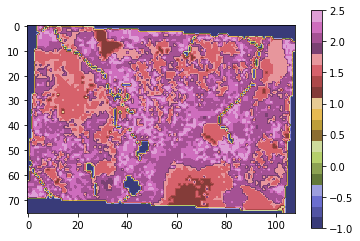

In [38]:
#plotting weighted average
plt.imshow(mokki_wtd_avg, cmap = 'tab20b')
# Add colorbar to show the index
plt.colorbar()

## TO DO
- add precipitation data
    * read in files
    * match crs
    * subset region
    * add to weighted overlay

**Resources**


Tahvanainen, Veera & Miina, Jari & Kurttila, Mikko. (2019). Climatic and Economic Factors Affecting the Annual Supply of Wild Edible Mushrooms and Berries in Finland. Forests. 10. 12. 10.3390/f10050385. 

Ihalainen, Marjut & Pukkala, Timo & Saastamoinen, Olli. (2005). Regional expert models for bilberry and cowberry yields in Finland. Boreal Environment Research. 10. 145-158. 